In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf


Using TensorFlow backend.


In [4]:
def read_custom_file(filename):
    data=tf.compat.as_str(open(filename,'r').read()).split()
    return data
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    #put the n_words(vocabulary size) most common words into the count
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    #zip creates an iterable object
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    #data -> entire text replaced by indexes into dictionary
    #count -> the count of n_words most common words such that {word,count}
    #dictionary -> the pair of {words, index} such that increading order of index corresponds to decreasing order of frequency of
    #occurance
    #reverse dictionary -> opposite of dictionary
    return data, count, dictionary, reversed_dictionary

def collect_data(filename,vocabulary_size=20):
    #filename is the path to the file of interest
    vocabulary = read_custom_file(filename)
    #read_data extracts the data from the file as a list or words
    # See the sixe of vocabulary
    #vocabulary is all the words in the dataset
    print("The total number of non distinct words in the dataset is ",len(vocabulary))
    #prints first 7 words of the text
    print(vocabulary[:7])
    data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                                vocabulary_size)
    del vocabulary  # Hint to reduce memory.
    # we dont need the original list of words
    return data, count, dictionary, reverse_dictionary

filename = 'C:/Users/RAHUL/projects/percy.txt'
vocab_size = 50
data, count, dictionary, reverse_dictionary = collect_data(filename,vocabulary_size=vocab_size)
#prints dictionary index of first 7 words
print(data[:7])

The total number of non distinct words in the dataset is  68
['The', 'whole', 'group', 'laughed.', 'Mr.', 'Brunner', 'stopped']
[9, 10, 11, 12, 3, 4, 13]


In [5]:
#now will query dictionary for word and reverse dictionary for index
print(dictionary["I"])
print(reverse_dictionary[1])

1
I


In [8]:
window_size = 3
#number of words around target word 
#i.e 3 words to the left of the target word and 3 words to the right of the target word
vector_dim = 300
# number of nodes in the hidden(embedding) layer
# causes embedding matrix to be of size (vocab_size x 300)
epochs = 1000000
#number of training iterations

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 50 # Only pick samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
#so will pick random 16 out of 100 most common words

In [9]:
print(valid_examples)

[27 13 46 25 38 43 32 28 34 19 26 12 17  8  2 11]


In [10]:
sampling_table = sequence.make_sampling_table(vocab_size)
#sampling table is used by skipgrams function to ensure it makes samples consisting of words in a balanced manner
#and not just the n most common layer
couples, labels = skipgrams(data, vocab_size, window_size=window_size, sampling_table=sampling_table)
#couples is the {word,context_word} pair and label corresponds whether its a real conext (1) or false (0)
word_target, word_context = zip(*couples)
#seperate out, word and context word
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[27, 47], [27, 3], [27, 32], [27, 4], [27, 13], [27, 28], [27, 1], [27, 6], [27, 29], [27, 27]] [0, 1, 0, 1, 0, 1, 1, 1, 0, 0]


In [11]:
# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

In [12]:
#we need to calculate the embedding vector for the target_word and the context_word
target = embedding(input_target)
#idk what unit they are working with
target = Reshape((vector_dim, 1))(target)
print(target)
#reshape to (300 x 1) for the dot product
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

Tensor("reshape_1/Reshape:0", shape=(?, 300, 1), dtype=float32)


In [13]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, dot

In [17]:
# setup a cosine similarity operation which will be output in a secondary model
similarity = dot([target, context],axes=0, normalize=True)
#(, mode='cos', dot_axes=0)

In [18]:
# now perform the dot product operation to get a similarity measure
dot_product = dot([target, context],axes=1, normalize=False)
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

In [19]:
# create the primary training model
model = Model(input=[input_target, input_context], output=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

c:\users\rahul\anaconda3\envs\miniproj2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [20]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(input=[input_target, input_context], output=similarity)

c:\users\rahul\anaconda3\envs\miniproj2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("do...)`
  


In [21]:
class SimilarityCallback:
    def run_sim(self):
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            sim = self._get_sim(valid_examples[i])
            nearest = (-sim).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocab_size,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        for i in range(vocab_size):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim
sim_cb = SimilarityCallback()

In [22]:
epochs=10000
loss_array=[]
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)
    loss_array.append(loss)
    if cnt % 100 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
    if cnt % 10000 == 0:
        sim_cb.run_sim()

Iteration 0, loss=0.6932412981987
Nearest to "No,: tell, comment?", felt, story., Mr., "did, you, group,
Nearest to stopped: at, represents?", to, laughed., Jackson,", "Perhaps, have, I,
Nearest to and: one, Jackson,", to, pointed, face, comment?", picture, pictures,
Nearest to totally: My, whole, one, represents?", Mr., carving,, said,, I,
Nearest to us: was, at, UNK, "did, his, group, "Mr., whole,
Nearest to looked: you'll, at, one, I, UNK, laughed., to, pictures,
Nearest to pictures: The, sir.", on, and, "Mr., a, relief,, you'll,
Nearest to sir.": you'll, pictures, said,, what, one, Jackson,", laughed., this,
Nearest to stele.: he, of, I, Mr., totally, have, tell, UNK,
Nearest to you: Jackson,", pointed, "No,, red., on, this, at, a,
Nearest to red.: his, represents?", felt, you, laughed., My, on, and,
Nearest to laughed.: The, UNK, "Mr., "Perhaps, looked, red., stopped, felt,
Nearest to he: stele., Jackson,", story., I, totally, stopped, one, a,
Nearest to of: was, to, comment?", at

In [23]:
#Alright now try to display embedding vector for a word
weights=np.array(embedding.get_weights())

In [24]:
print(weights[0][10].shape)
reverse_dictionary[10]
print(reverse_dictionary)
#good now to get weights of a perticular word?
# now print 8 words near it"

(300,)
{0: 'UNK', 1: 'I', 2: 'the', 3: 'Mr.', 4: 'Brunner', 5: 'his', 6: 'said,', 7: 'a', 8: 'of', 9: 'The', 10: 'whole', 11: 'group', 12: 'laughed.', 13: 'stopped', 14: 'story.', 15: '"Mr.', 16: 'Jackson,"', 17: 'he', 18: '"did', 19: 'you', 20: 'have', 21: 'comment?"', 22: 'My', 23: 'face', 24: 'was', 25: 'totally', 26: 'red.', 27: '"No,', 28: 'sir."', 29: 'pointed', 30: 'to', 31: 'one', 32: 'pictures', 33: 'on', 34: 'stele.', 35: '"Perhaps', 36: "you'll", 37: 'tell', 38: 'us', 39: 'what', 40: 'this', 41: 'picture', 42: 'represents?"', 43: 'looked', 44: 'at', 45: 'carving,', 46: 'and', 47: 'felt', 48: 'flush', 49: 'relief,'}


In [25]:
class SimilarityCallback_single_word:
    def run_sim(self,index):
        valid_word = reverse_dictionary[index]
        top_k = 8  # number of nearest neighbors
        sim = self._get_sim(index)
        nearest = (-sim).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = '%s %s,' % (log_str, close_word)
        print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocab_size,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        for i in range(vocab_size):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim
sim_cb_single_word = SimilarityCallback_single_word()

In [26]:
sim_cb_single_word.run_sim(48)

Nearest to flush: of, Mr., relief,, I, "did, Brunner, sir.", said,,


In [28]:
print(dictionary)

{'UNK': 0, 'I': 1, 'the': 2, 'Mr.': 3, 'Brunner': 4, 'his': 5, 'said,': 6, 'a': 7, 'of': 8, 'The': 9, 'whole': 10, 'group': 11, 'laughed.': 12, 'stopped': 13, 'story.': 14, '"Mr.': 15, 'Jackson,"': 16, 'he': 17, '"did': 18, 'you': 19, 'have': 20, 'comment?"': 21, 'My': 22, 'face': 23, 'was': 24, 'totally': 25, 'red.': 26, '"No,': 27, 'sir."': 28, 'pointed': 29, 'to': 30, 'one': 31, 'pictures': 32, 'on': 33, 'stele.': 34, '"Perhaps': 35, "you'll": 36, 'tell': 37, 'us': 38, 'what': 39, 'this': 40, 'picture': 41, 'represents?"': 42, 'looked': 43, 'at': 44, 'carving,': 45, 'and': 46, 'felt': 47, 'flush': 48, 'relief,': 49}


In [40]:
word_list=read_custom_file('C:/Users/RAHUL/projects/percy.txt')
print(word_list)

['The', 'whole', 'group', 'laughed.', 'Mr.', 'Brunner', 'stopped', 'his', 'story.', '"Mr.', 'Jackson,"', 'he', 'said,', '"did', 'you', 'have', 'a', 'comment?"', 'My', 'face', 'was', 'totally', 'red.', 'I', 'said,', '"No,', 'sir."', 'Mr.', 'Brunner', 'pointed', 'to', 'one', 'of', 'the', 'pictures', 'on', 'the', 'stele.', '"Perhaps', "you'll", 'tell', 'us', 'what', 'this', 'picture', 'represents?"', 'I', 'looked', 'at', 'the', 'carving,', 'and', 'felt', 'a', 'flush', 'of', 'relief,', 'because', 'I', 'actually', 'recognized', 'it.', '"That\'s', 'Kronos', 'eating', 'his', 'kids,', 'right?']


In [32]:
#plot loss vs number of iterations and visualize word embeddings
import matplotlib.pyplot as plt

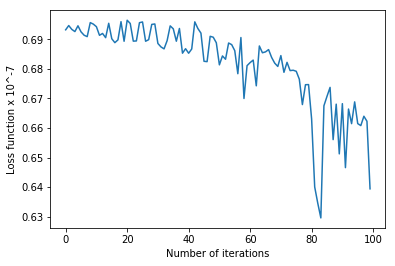

In [52]:
plt.plot(loss_array[:100])
plt.xlabel('Number of iterations')
plt.ylabel('Loss function x 10^-7')
plt.show()

In [34]:
print(loss_array)

[0.6932413, 0.6946824, 0.6933813, 0.6926465, 0.694599, 0.6925451, 0.6914101, 0.69093436, 0.69568247, 0.69517046, 0.6942993, 0.6913821, 0.692009, 0.6905845, 0.69545263, 0.6902122, 0.68889654, 0.68982714, 0.69599736, 0.6893643, 0.6964814, 0.69539696, 0.6894039, 0.6894727, 0.6956511, 0.6959031, 0.6893696, 0.6899052, 0.6950693, 0.6952207, 0.6886171, 0.6874511, 0.6867934, 0.68957675, 0.6945788, 0.69358087, 0.68938273, 0.69369674, 0.6853268, 0.68684363, 0.68531215, 0.686749, 0.6959345, 0.6936908, 0.6921163, 0.6825854, 0.68246806, 0.69104594, 0.690735, 0.6888627, 0.68138486, 0.68440366, 0.68328017, 0.6887749, 0.6882238, 0.6861886, 0.67838216, 0.6906282, 0.66999996, 0.6811145, 0.68215114, 0.6829922, 0.6742835, 0.6877737, 0.6854731, 0.68577397, 0.6865436, 0.68387496, 0.6819543, 0.68083954, 0.68451285, 0.6788582, 0.6822315, 0.6794368, 0.6795599, 0.6792075, 0.67652035, 0.6679357, 0.6746572, 0.6747004, 0.6630504, 0.6400575, 0.6345518, 0.6295674, 0.66752243, 0.67071116, 0.67375255, 0.6560671, 0.668

In [37]:
from sklearn.manifold import TSNE

In [49]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [50]:
#alright now visualize word embeddings
conv_embds = weights[0]

## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    #py.iplot(fig)
    return fig

## Visualize words in two dimensions 
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)
fig=plot_words(conv_tsne_embds, 0, 2000, 1)

In [51]:
py.iplot(fig)